In [1]:
import torch
import pickle
import argparse
from collections import defaultdict
from util import get_image_size
from tqdm import tqdm
from unet_power import UNet
from model import DiffusionModel
from util import get_transforms
import matplotlib.pyplot as plt


In [2]:
def infer(unet, diffusion_model, device, reverse_transform, n, image_size):
    unet.eval()
    with torch.no_grad():
        image = torch.randn((n, *image_size)).to(device)
        for i in reversed(range(diffusion_model.timesteps)):
            image = diffusion_model.backward(image, torch.full((1, ), i, dtype=torch.long, device=device), unet)
        print(image.size())
        image = torch.permute(reverse_transform(image).to(torch.uint8), (0, 2, 3, 1)).cpu()

    fig, axes = plt.subplots(1, n, figsize=(10 * n, 10))
    for i, ax in enumerate(axes):
        ax.imshow(image[i])
    plt.show()

torch.Size([10, 3, 32, 32])


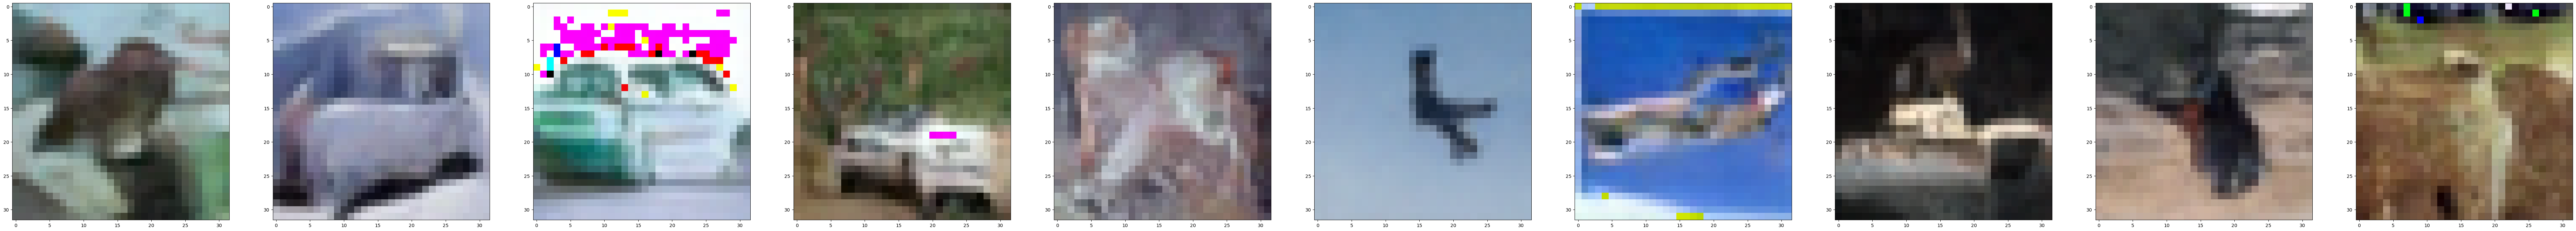

In [3]:
device = 'cuda'
TIMESTEPS = 1000
IMAGE_SIZE = (3, 32, 32)
N = 10

_, reverse_transform = get_transforms(image_size=IMAGE_SIZE[1:])

unet = UNet(T=TIMESTEPS,
            ch=32,
            ch_mult=[1,2,2,2],
            attn=[1],
            num_res_blocks=2,
            dropout=0.1, in_ch=IMAGE_SIZE[0]).to(device)
unet.load_state_dict(torch.load('weight/parameters_power.pkl'))
diffusion_model = DiffusionModel(timesteps=TIMESTEPS)
infer(unet, diffusion_model, device, reverse_transform, N, IMAGE_SIZE)